In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seal_img_filename = 'seal_cup_tooth.tif'
seal_img_full = cv2.imread(seal_img_filename)

In [3]:
seal_img_full.shape
ds_vals = 1.0/ np.array([1,2,4,8,16])

seal_img_gray = cv2.cvtColor(seal_img_full,cv2.COLOR_RGB2GRAY)
multi_res_pyr = [cv2.resize(seal_img_gray, dsize = (0,0),fx = ds_mult, fy= ds_mult, interpolation = cv2.INTER_AREA) for ds_mult in ds_vals]


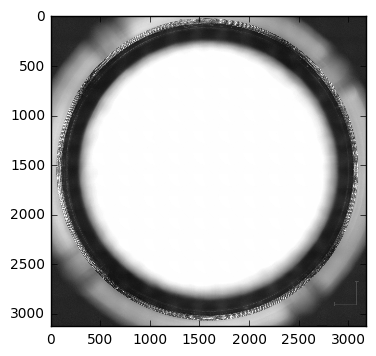

In [110]:
plt.imshow(multi_res_pyr[-3],cmap='gray')

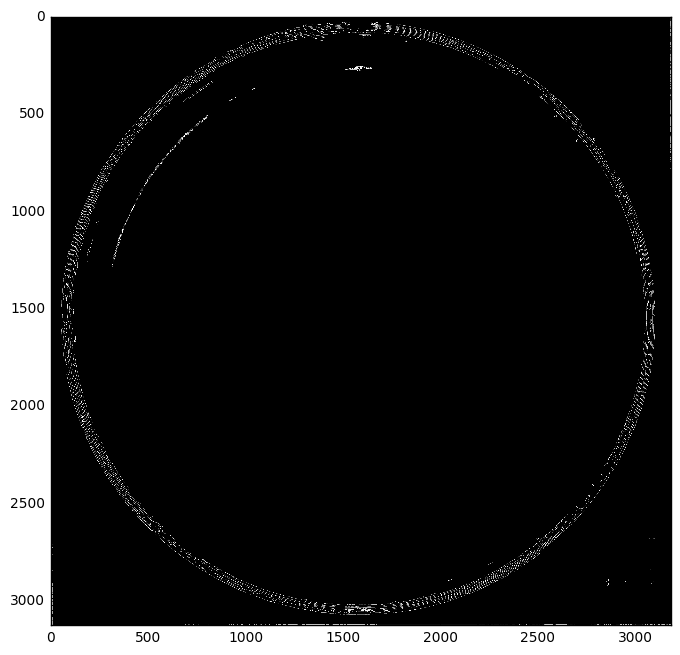

In [108]:
from skimage import data, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

#Work on lowest res image
img =  multi_res_pyr[-3].copy()
ds_val = ds_vals[-3]
img_dims = img.shape

edges = canny(img, sigma=3, low_threshold=20, high_threshold=30)
plt.figure(figsize=(8,8))
plt.imshow(edges,cmap ='gray')


In [109]:
# Detect two radii
min_r = 0.9*img_dims[0]/2.0
max_r = 1.0*img_dims[0]/2.0
    
hough_radii = np.arange(min_r, max_r, 1)
hough_res = hough_circle(edges, hough_radii)

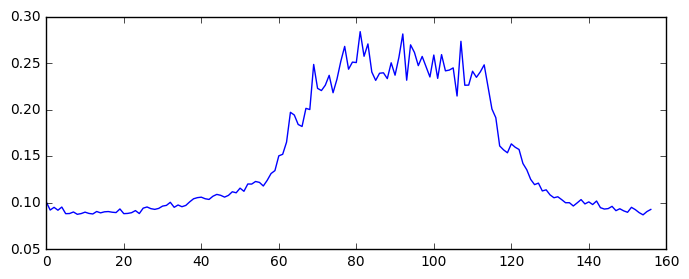

In [119]:
centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract a circle
    num_peaks = 1
    peaks = peak_local_max(h, num_peaks=num_peaks)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius] * num_peaks)
    

#Find beginning and end of threaded portion
peak_inds = peak_local_max(np.array(accums), num_peaks=2)



Peak index = 90
FWHM 52.3567039078
Range of bands: 64 -> 118


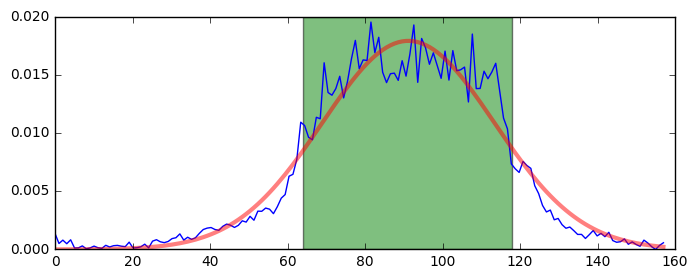

In [144]:
accums -= np.min(accums)
accums = accums / np.sum(accums)

peak_indices = find_peaks_cwt(accums,np.array([len(accums)//2]))

peak_index = peak_indices[0]
print ("Peak index = {}".format(peak_index))

import scipy.optimize as opt

def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

# Fit a guassian
X= np.linspace(0,len(accums), len(accums))
p0 = [peak_index,1] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
p1, success = opt.leastsq(errfunc, p0[:], args=(X, accums))

fit_mu, fit_stdev = p1

FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print ("FWHM", FWHM)

min_idx = int(np.floor(fit_mu-FWHM/2))
max_idx = int(np.ceil( fit_mu+FWHM/2))
print ("Range of bands: {} -> {}".format(min_idx,max_idx))
#Plot the peaks in the transform - these will be the beginning and end of the threaded portion
plt.figure (figsize = (8,3))
plt.plot(X,accums)
plt.plot(X, gauss(X,p1),lw=3,alpha=.5, color='r')
ax = plt.axvspan(min_idx, max_idx, facecolor='g', alpha=0.5)


In [273]:
from scipy.signal import resample

bands = []
band_dims = []
radius_vals = []
bands_eq_len = []
band_eq_vec = np.linspace(0,10000,20000)

#For all radii between min and max index, extract the image as a band
for idx in range(min_idx,max_idx):
    radius = radii[idx]
    radius_vals.append(radius)

    center_x, center_y = centers[idx]
    cx, cy = circle_perimeter(center_y, center_x, int(radius))
    
    band = img[cx,cy][0:10000]
    bands.append(band) #- np.mean(band))
    band_dims.append(np.linspace(0,2*np.pi,len(bands[-1])))
    
    #Played with resampling to make equal length, but results weren't very good
    #f = resample(bands[-1],len(band_eq_vec))
    #bands_eq_len.append(f)
    #f = interp1d (band_dims[-1],bands[-1])
    #bands_eq_len.append(f(band_eq_vec))
    


In [271]:
nbands = len(bands)
print ("Number of bands: {}".format(nbands))

band_img = []
#fr band in bands_eq_len:
for band in bands:
    band = band[0:len(bands[0])]
    band_img.append (band)
band_img = np.reshape (np.array(band_img), (len(band_img),len(band)))




Number of bands: 54


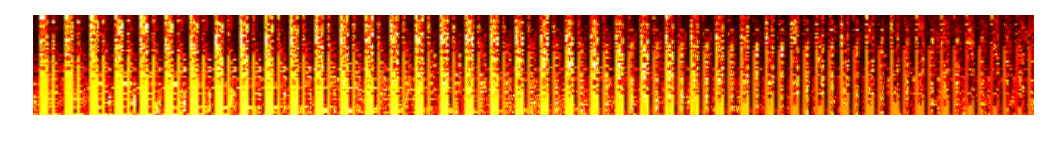

In [272]:
fig = plt.figure(figsize=(10,1))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.set_cmap('hot')
ax.imshow(band_img, aspect = 'auto')
plt.show()

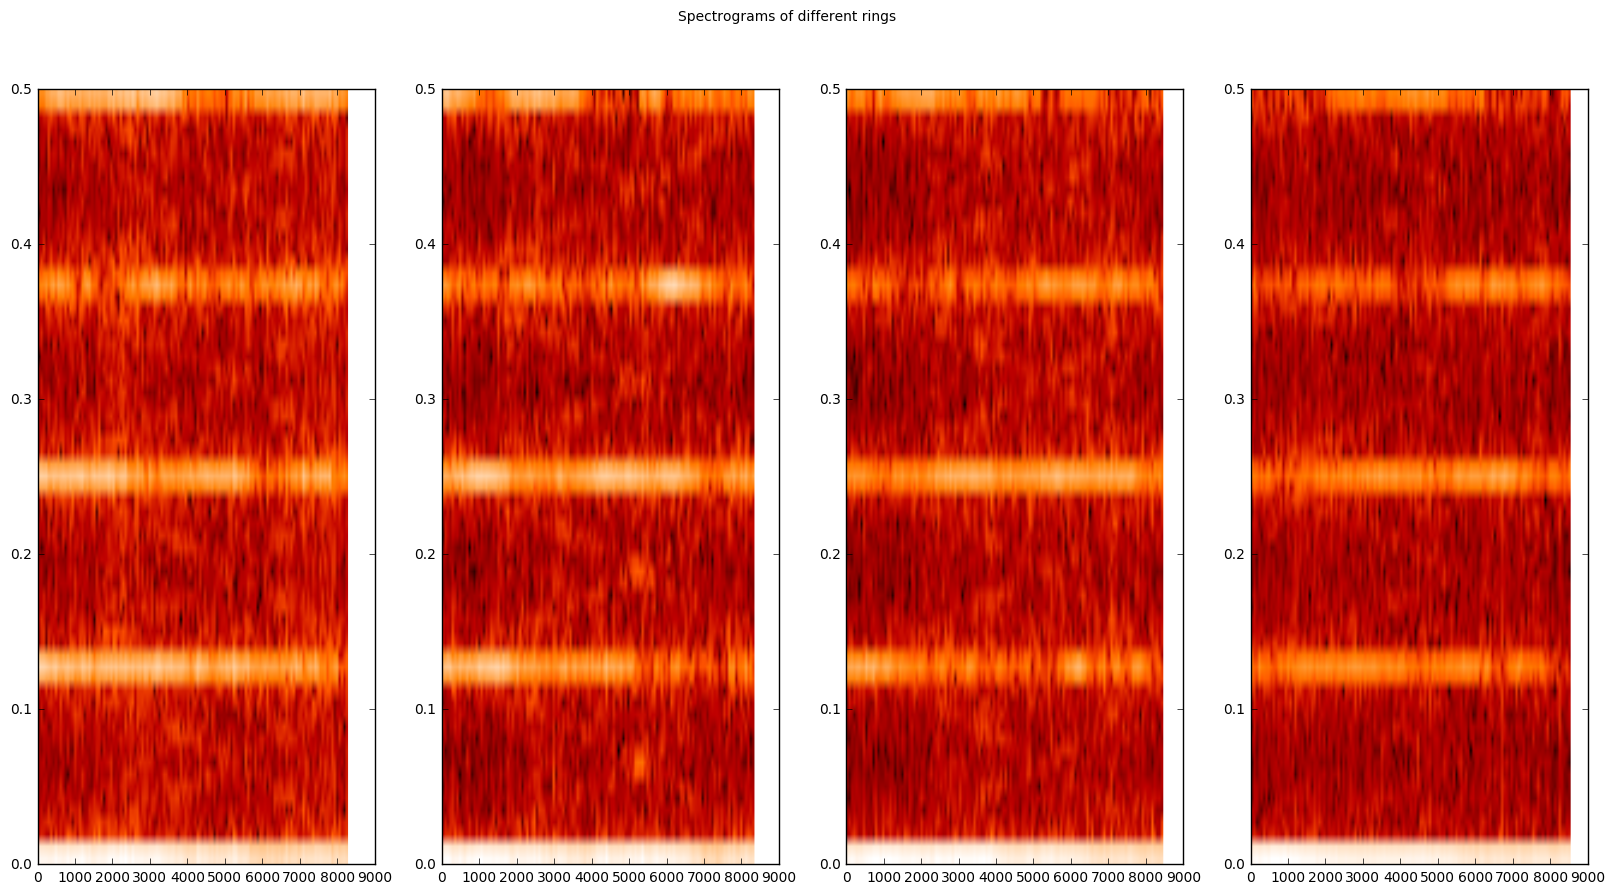

In [207]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4,figsize=(20,10))
fig.suptitle("Spectrograms of different rings")
spec1, freqs, t, im = ax1.specgram(bands[0], NFFT=128, Fs=1, noverlap=64,
                                cmap=plt.cm.gist_heat)
spec2, freqs, t, im = ax2.specgram(bands[nbands//3], NFFT=128, Fs=1, noverlap=64,
                                cmap=plt.cm.gist_heat)
spec3, freqs, t, im = ax3.specgram(bands[2*nbands//3], NFFT=128, Fs=1, noverlap=64,
                                cmap=plt.cm.gist_heat)
spec4, freqs, t, im = ax4.specgram(bands[-1], NFFT=128, Fs=1, noverlap=64,
                                cmap=plt.cm.gist_heat)

In [ ]:
specsum = np.zeros_like(spec1)
ts = []

for band in bands:
    spec, freqs, t, _ = ax1.specgram(bands[0], NFFT=128, Fs=1, noverlap=64,cmap=plt.cm.gist_heat)
    spec += spec[:,0:specsum.shape[1]]
    ts.append (t)
    
xextent=(0,np.amax(ts[0]))
xmin, xmax = xextent
extent = xmin, xmax, freqs[0], freqs[-1]
Z = 10. * np.log10(spec)

plt.figure(figsize=(5,10))
plt.title("Summed spectrograms, probably not a great idea")
plt.imshow(Z,extent=extent,cmap = 'hot')
plt.axis('auto')
plt.xlim (0,len(bands[-1]))
plt.ylim ([0,0.5])


In [ ]:
#Alternative version using simple blob detector
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 1500

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.5
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.5
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.5


out_imgs = []

for im,ds_val in zip(multi_res_pyr, ds_vals):
    img_dims = im.shape
    #Max is circle filling image
    params.maxArea = np.pi * (img_dims[0]/2.0)**2
     
    # Create a detector with the parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3 :
        detector = cv2.SimpleBlobDetector(params)
    else : 
        detector = cv2.SimpleBlobDetector_create(params)
    
    keypoints = detector.detect(im)
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    out_imgs.append(im_with_keypoints)
    
plt.figure (figsize = (10,10))
plt.imshow(out_imgs[3])
    
#for im,ds_val in zip(multi_res_pyr, ds_vals):
im =  multi_res_pyr[3].copy()
ds_val = ds_vals[3]

img_dims = im.shape
#Max is circle filling image
mser = cv2.MSER_create(_delta = 30, 
                       _min_area = int(np.pi * (0.5 * img_dims[0]/2.0)**2), 
                       _max_area = int(np.pi * (1.0 * img_dims[0]/2.0)**2),
                       _max_variation = 0.2,
                       _min_diversity = 0,
                       _max_evolution = 200,
                       _area_threshold = 1.01,
                       _min_margin = 0.003,
                       _edge_blur_size = 1 )
regions = mser.detectRegions(im, None)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
vis = cv2.polylines(im.copy(), hulls, 1, (0, 255, 0))

plt.figure (figsize=(10,10))
plt.imshow (vis)